<a href="https://colab.research.google.com/github/MehrdadJalali-AI/Statistics-and-Machine-Learning/blob/main/InClass/C2_Data_Preprocessing_Cont.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Exercise (2): Data Preprocessing
This notebook demonstrates handling missing values, scaling, noise, outliers, and feature selection.

## 1. Load Dataset
We create a simple mixed-type dataset with numerical and categorical features.

In [1]:

import numpy as np
import pandas as pd

np.random.seed(42)

data = pd.DataFrame({
    'Age': [25, 30, np.nan, 45, 50, 35, np.nan],
    'Salary': [50000, 60000, 55000, 80000, 120000, 70000, 65000],
    'Department': ['IT', 'HR', 'IT', 'Finance', 'Finance', 'HR', 'IT']
})

data


,Age,Salary,Department
0,25.0,50000,IT
1,30.0,60000,HR
2,NaN,55000,IT
3,45.0,80000,Finance
4,50.0,120000,Finance
5,35.0,70000,HR
6,NaN,65000,IT


## 2. Handling Missing Values
We impute numerical features using the median and categorical features using the mode.

In [2]:

data['Age'] = data['Age'].fillna(data['Age'].median())
data


,Age,Salary,Department
0,25.0,50000,IT
1,30.0,60000,HR
2,35.0,55000,IT
3,45.0,80000,Finance
4,50.0,120000,Finance
5,35.0,70000,HR
6,35.0,65000,IT


## 3. Scaling Data
We apply Z-score standardization and Min-Max normalization to numerical features.

In [3]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
data[['Age_z', 'Salary_z']] = scaler.fit_transform(data[['Age', 'Salary']])

minmax = MinMaxScaler()
data[['Age_mm', 'Salary_mm']] = minmax.fit_transform(data[['Age', 'Salary']])

data


,Age,Salary,Department,Age_z,Salary_z,Age_mm,Salary_mm
0,25.0,50000,IT,-1.448572,-0.981630,0.0,0.000000
1,30.0,60000,HR,-0.814822,-0.523536,0.2,0.142857
2,35.0,55000,IT,-0.181071,-0.752583,0.4,0.071429
3,45.0,80000,Finance,1.086429,0.392652,0.8,0.428571
4,50.0,120000,Finance,1.720179,2.225028,1.0,1.000000
5,35.0,70000,HR,-0.181071,-0.065442,0.4,0.285714
6,35.0,65000,IT,-0.181071,-0.294489,0.4,0.214286


## 4. Handling Noise
We inject random noise into the salary feature and smooth it using a rolling mean.
### Rolling Mean Smoothing

This line applies a rolling (moving) average to smooth noisy salary values by replacing each value with the average of the current and previous values within a window of size 3. The parameter `min_periods=1` ensures that the mean is computed even at the beginning of the dataset when fewer values are available, instead of returning missing values. For example, if the noisy salary values are `[50, 80, 40, 60]`, the rolling mean becomes `[50, 65, 56.7, 60]`, because the first values are calculated using only the available data points. Overall, rolling mean smoothing reduces random noise while preserving the underlying trend in the data.


In [11]:

data['Salary_noisy'] = data['Salary'] + np.random.normal(0, 20000, size=len(data))
data['Salary_smooth'] = data['Salary_noisy'].rolling(window=3, min_periods=1).mean()
data[['Salary', 'Salary_noisy', 'Salary_smooth']]


,Salary,Salary_noisy,Salary_smooth
0,50000,37987.226202,37987.226202
1,60000,54166.125004,46076.675603
2,55000,42965.867755,45039.739654
3,80000,117045.563690,71392.518817
4,120000,119730.055505,93247.162317
5,70000,48845.781421,95207.133539
6,65000,81450.898242,83342.245056


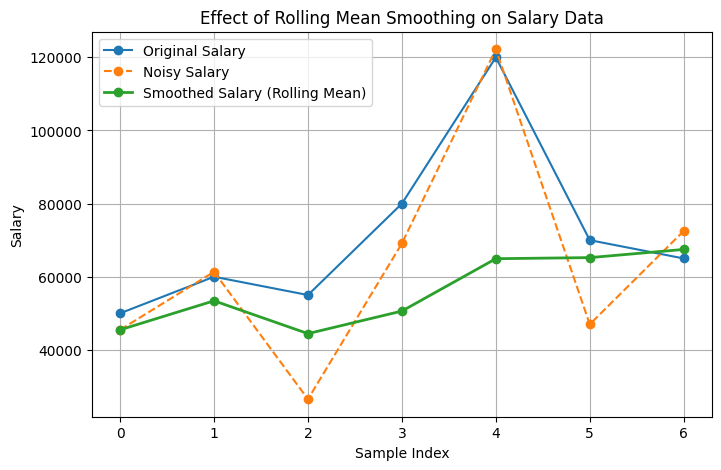

In [10]:
import matplotlib.pyplot as plt

# Create an index for plotting (e.g. sample number)
x = range(len(data))

plt.figure(figsize=(8, 5))

plt.plot(x, data['Salary'], marker='o', label='Original Salary')
plt.plot(x, data['Salary_noisy'], marker='o', linestyle='--', label='Noisy Salary')
plt.plot(x, data['Salary_smooth'], marker='o', linewidth=2, label='Smoothed Salary (Rolling Mean)')

plt.xlabel('Sample Index')
plt.ylabel('Salary')
plt.title('Effect of Rolling Mean Smoothing on Salary Data')
plt.legend()
plt.grid(True)

plt.show()


## 5. Handling Outliers
We detect outliers using Z-score and remove them.

In [12]:

from scipy.stats import zscore

z_scores = np.abs(zscore(data['Salary']))
data['Outlier'] = z_scores > 2
data


,Age,Salary,Department,Age_z,Salary_z,Age_mm,Salary_mm,Salary_noisy,Salary_smooth,Outlier
0,25.0,50000,IT,-1.448572,-0.981630,0.0,0.000000,37987.226202,37987.226202,False
1,30.0,60000,HR,-0.814822,-0.523536,0.2,0.142857,54166.125004,46076.675603,False
2,35.0,55000,IT,-0.181071,-0.752583,0.4,0.071429,42965.867755,45039.739654,False
3,45.0,80000,Finance,1.086429,0.392652,0.8,0.428571,117045.563690,71392.518817,False
4,50.0,120000,Finance,1.720179,2.225028,1.0,1.000000,119730.055505,93247.162317,True
5,35.0,70000,HR,-0.181071,-0.065442,0.4,0.285714,48845.781421,95207.133539,False
6,35.0,65000,IT,-0.181071,-0.294489,0.4,0.214286,81450.898242,83342.245056,False


## 6. Feature Selection
We compare filter, wrapper, and embedded methods.

### 6.1 Filter Method (Correlation)

In [13]:

data[['Age', 'Salary']].corr()


,Age,Salary
Age,1.000000,0.900576
Salary,0.900576,1.000000


### 6.2 Wrapper Method (Recursive Feature Elimination)

In [14]:

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

X = data[['Age', 'Salary']]
y = data['Salary']

model = LinearRegression()
rfe = RFE(model, n_features_to_select=1)
rfe.fit(X, y)

pd.DataFrame({'Feature': X.columns, 'Selected': rfe.support_})


,Feature,Selected
0,Age,False
1,Salary,True


### 6.3 Embedded Method (Lasso Regression)

In [15]:

from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X, y)

pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso.coef_})


,Feature,Coefficient
0,Age,0.0
1,Salary,1.0
